In [17]:
import numpy as np
from PIL import Image
import PIL
from matplotlib import pyplot as plt
import math

from glob import glob
import os
import random
from dicttoxml import dicttoxml

import ipywidgets as widgets
from IPython.display import display

# http://blog.mmast.net/python-image-processing-libraries-performance-opencv-scipy-scikit-image

In [18]:
%matplotlib inline

In [19]:
def open_image(path):
    img = Image.open(path)
    img = img.convert('RGB')
    return img

In [20]:
# list with class labels, replace with your labels
object_names = ["4016931020532", "4016931020563"]

In [21]:
# Put the images to be inserted onto backgrounds
images_path = "./to_augment"
images_list = glob(os.path.join(images_path, '*'))
images_to_augment = list(map(open_image, images_list))

In [22]:
import numpy
from functools import reduce
def rand_perspective(im, coeff):
    img = im.convert('RGBA')

    def find_coeffs(pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append(
                [p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
            matrix.append(
                [0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

        A = numpy.matrix(matrix, dtype=numpy.float)
        B = numpy.array(pb).reshape(8)

        res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
        return numpy.array(res).reshape(8)

    def tuple_diff(left, right):
        result = []
        for l, r in zip(left, right):
            result.append(l - r)
        return tuple(result)

    dx = int(coeff * img.width)
    dy = int(coeff * img.height)

    fromm = [(0, 0), (img.width, 0), (img.width, img.height), (0, img.height)]
    to = []

    for point in fromm:
        x = random.randint(-dx, dx) + point[0]
        y = random.randint(-dy, dy) + point[1]
        to.append((x, y))

    minn = (reduce(min, map(lambda x: x[0], to)),
            reduce(min, map(lambda y: y[1], to)))
    maxx = (reduce(max, map(lambda x: x[0], to)),
            reduce(max, map(lambda y: y[1], to)))

    new_size = tuple_diff(maxx, minn)

    to = tuple([tuple_diff(x, minn) for x in to])

    coeffs = find_coeffs(to, fromm)
    img = img.transform(new_size, Image.PERSPECTIVE, coeffs, Image.BICUBIC)
    return img

In [23]:
img = images_to_augment[0]

In [25]:
def perspective_changed(change):
    zz = rand_perspective(img, change.new)
    plt.imshow(zz)
w_perspective = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.02,
    description='Perspective coeff:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
w_perspective.observe(perspective_changed, names='value')

display(w_perspective)

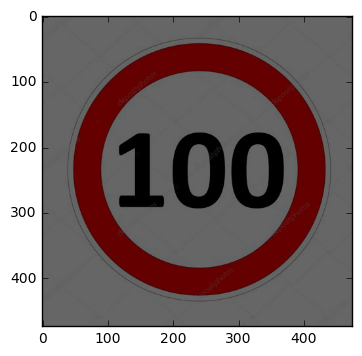

In [26]:
from PIL import ImageEnhance

brightness_enchancer = ImageEnhance.Brightness(img)

def brightness_changed(change):
    zz = brightness_enchancer.enhance(change.new)
    plt.imshow(zz)

w = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.05,
    description='Brightness:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
w.observe(brightness_changed, names='value')

display(w)

In [27]:
images_to_augment = list(map(lambda x: np.array(x, dtype=np.uint8), images_to_augment))

In [28]:
def grid(images, rows, cols, border=1, border_color=255):
    nb_images = len(images)
    cell_height = max([image.shape[0] for image in images])
    cell_width = max([image.shape[1] for image in images])
    channels = set([image.shape[2] for image in images])
    assert len(channels) == 1
    nb_channels = list(channels)[0]
    if rows is None and cols is None:
        rows = cols = int(math.ceil(math.sqrt(nb_images)))
    elif rows is not None:
        cols = int(math.ceil(nb_images / rows))
    elif cols is not None:
        rows = int(math.ceil(nb_images / cols))
    assert rows * cols >= nb_images

    cell_height = cell_height + 1 * border
    cell_width = cell_width + 1 * border

    width = cell_width * cols
    height = cell_height * rows
    grid = np.zeros((height, width, nb_channels), dtype=np.uint8)
    cell_idx = 0
    for row_idx in range(rows):
        for col_idx in range(cols):
            if cell_idx < nb_images:
                image = images[cell_idx]
                border_top = border_right = border_bottom = border_left = border
                #if row_idx > 1:
                border_top = 0
                #if col_idx > 1:
                border_left = 0
                image = np.pad(image, ((border_top, border_bottom), (border_left, border_right), (0, 0)), mode="constant", constant_values=border_color)

                cell_y1 = cell_height * row_idx
                cell_y2 = cell_y1 + image.shape[0]
                cell_x1 = cell_width * col_idx
                cell_x2 = cell_x1 + image.shape[1]
                grid[cell_y1:cell_y2, cell_x1:cell_x2, :] = image
            cell_idx += 1

    grid = np.pad(grid, ((border, 0), (border, 0), (0, 0)), mode="constant", constant_values=border_color)

    return grid

In [29]:
def save_image(np_image, filename):
    image = Image.fromarray(np_image)
    image.save(filename + ".png")

In [35]:
coco_images_path = "./coco_dataset/*.jpg" 
coco_images_list = glob(coco_images_path)

In [36]:
coco_images_list

['./coco_dataset\\374320_screenshots_20161112174521_1.jpg',
 './coco_dataset\\Horizon Zero Dawn™_20170325132856.jpg',
 './coco_dataset\\Horizon Zero Dawn™_20170328231846.jpg']

In [39]:
idx = 0
for obj_name, img in zip(object_names, images_to_augment):
    images_aug = [img] * 5
    
    for img in images_aug:
        forground_img = Image.fromarray(img)
        background_img = Image.open(random.choice(coco_images_list))
        
        brightness_enchancer = ImageEnhance.Brightness(forground_img)
        forground_img = brightness_enchancer.enhance(random.uniform(0.65, 1.0))
        forground_img = forground_img.convert('RGBA')
        
        forground_img = rand_perspective(forground_img, 0.1)

        # forground_img = forground_img.rotate(int(random.gauss(0, 11)), expand=1)
        part = random.uniform(0.05, 0.3)

        forground_ratio = forground_img.size[0] / forground_img.size[1]
        if background_img.size[0] > background_img.size[1]:
            width = background_img.size[0] * part
            height = width / forground_ratio

            if height > background_img.size[1]:
                height = background_img.size[1]
                width = height * forground_ratio
        else:
            height = background_img.size[1] * part
            width = height * forground_ratio

            if width > background_img.size[0]:
                width = background_img.size[0]
                height = width / forground_ratio

        width = int(width)
        height = int(height)
        x = random.randint(0, background_img.size[0] - width)
        y = random.randint(0, background_img.size[1] - height)

        f_img = forground_img.resize((width, height))
        background_img.paste(f_img, (x, y), f_img)

        name = "img_{:07}".format(idx)
        background_img.save("./images/{}.jpg".format(name))

        annotation = {}
        annotation["filename"] = "{}.jpg".format(name)
        size = {"width": background_img.size[0],
               "height": background_img.size[1],
               "depth": 3}
        annotation["size"] = size
        annotation["segmented"] = 0
        obj = {
            "name": obj_name,
            "pose": "Unspecified",
            "truncated": 0,
            "difficult": 0,
            "bndbox": {
                "xmin": x,
                "ymin": y,
                "xmax": x + width,
                "ymax": y + height
            }
        }
        annotation["object"] = obj
        xml = dicttoxml(annotation, custom_root='annotation', attr_type=False)
        with open("./annotations/{}.xml".format(name), "wb") as f:
            f.write(xml)
        idx += 1

In [107]:
# gr = grid(images_aug, cols=8, rows=4)
# plt.imshow(gr)
# save_image(gr, "grid")

# https://stackoverflow.com/a/14178717
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=numpy.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)